# Categorical Data - Category Frequency and Rare values

## Labels that occur rarely

Categorical variables are those which values are selected from a group of categories, also called labels. Different labels appear in  the dataset with different frequencies. Some categories appear a lot in the dataset, whereas some other categories appear only in a few number of observations.

For example, in dataset with information about loan applicants where one of the variables is "city" where the applicant lives, cities like 'New York' may appear a lot in the data because New York has a huge population, whereas smaller towns like 'Leavenworth' will appear only on a few occasions (if at all, population < 2000 people), because the population there is very small. A borrower is more likely to live in New York, because far more people live in New York.

In fact, categorical variables often contain a few dominant labels that account for the majority of the observations and a large number of labels that appear only seldomly.


### Are Rare Labels in a categorical variable a problem?

Rare values can add a lot of information or none at all. For example, consider a stockholder meeting where each person can vote in proportion to their number of shares. One of the shareholders owns 50% of the stock, and the other 999 shareholders own the remaining 50%. The outcome of the vote is largely influenced by the shareholder who holds the majority of the stock. The remaining shareholders may have an impact collectively, but they have almost no impact individually.  

The same occurs in real life datasets. The label that is over-represented in the dataset tends to dominate the outcome, and those that are under-represented may have no impact individually, but could have an impact if considered collectively.

More specifically,

- Rare values in categorical variables tend to cause over-fitting, particularly in tree based methods.

- A big number of infrequent labels adds noise, with little information, therefore causing over-fitting.

- Rare labels may be present in training set, but not in test set, therefore causing over-fitting to the train set.

- Rare labels may appear in the test set, and not in the train set. Thus, the machine learning model will not know how to evaluate it. 


**Note** Sometimes rare values, are indeed important. For example, if we are building a model to predict fraudulent loan applications, which are by nature rare, then a rare value in a certain variable, may be indeed important. This rare value could be telling us that the observation is most likely a fraudulent application, and therefore we would choose not to ignore it.

I will show how to tackle rare labels in later notebooks. Here I will demonstrate the presence of rare labels in a dataset, and how difficult it is to derive reliable information from them.

## Real Life example: 

### The Mercedes-Benz Greener Manufacturing challenge in Kaggle

Daimler’s Mercedes-Benz cars are leaders in the premium car industry. With a huge selection of car features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of each and every unique car configuration before they hit the road, Daimler’s engineers have developed a robust testing system. Testing time varies depending on the different car features and options. The task is to predict the time it takes for a car with certain features to pass the testing. Therefore it is a regression problem: we need to estimate a continuous variable.

The dataset contains a set of car features, the variable names are masked, so it is impossible to find out what each one of them means. The variable to predict is _y_: time to pass the testing.

====================================================================================================

To download the Mercedes-Benz Greener Manufacturing dataset from Kaggle go ahead to this [website](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/data)

Scroll down to the bottom of the page, and click on the link 'train.csv.zip', and then click the 'download' blue button towards the right of the screen, to download the dataset.
Unzip it, and save it to a directory of your choice.

**Note that you need to be logged in to Kaggle in order to download the datasets**.

If you save it in the same directory from which you are running this notebook and name the file 'mercedesbenz.csv' then you can load it the same way I will load it below.

====================================================================================================

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
# let's load the dataset with the variables
# we need for this demo

data = pd.read_csv('mercedesbenz.csv',
                   usecols=['X1', 'X2', 'X3', 'X6', 'y'])
data.head()

,y,X1,X2,X3,X6
0,130.81,v,at,a,j
1,88.53,t,av,e,l
2,76.26,w,n,c,j
3,80.62,t,n,f,l
4,78.02,v,n,f,d


Variable names and variable values are masked intentionally by Mercedes Benz. This is common practice, it is done to protect intellectual property and / or personal information.

In [3]:
# let's look at the different number of labels
# in each variable

cols_to_use = ['X1', 'X2', 'X3', 'X6']

for col in cols_to_use:
    print('variable: ', col, ' number of labels: ', len(data[col].unique()))

print('total cars: ', len(data))

variable:  X1  number of labels:  27
variable:  X2  number of labels:  44
variable:  X3  number of labels:  7
variable:  X6  number of labels:  12
total cars:  4209


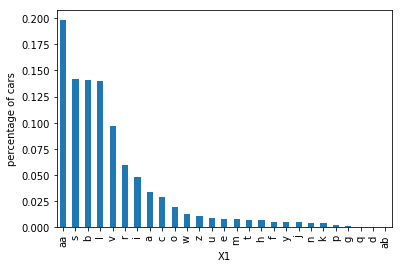

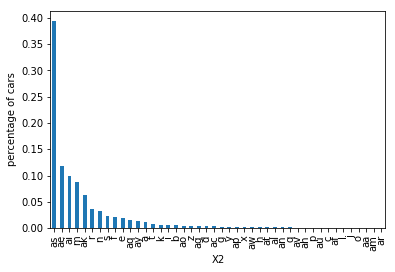

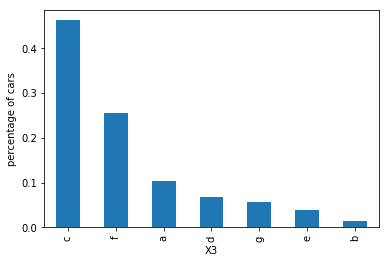

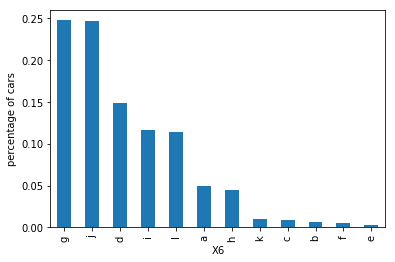

In [4]:
# let's plot how frequently each label 
# appears in the dataset

# in other words, the percentage of cars that
# show each label

total_cars = len(data)

for col in cols_to_use:
    
    # count the number of cars per label / category
    # and divide by total cars
    
    # aka percentage of cars per category
    
    temp_df = pd.Series(data[col].value_counts() / total_cars)
    
    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)
    fig.set_ylabel('percentage of cars')
    plt.show()

For each of the above variables, some labels appear in more than 10% of the cars and many appear in less than 10% or even 5% of the cars. These are infrequent labels or **Rare Values** and could cause over-fitting.

### How is the target, "time to pass testing", related to these categories?

In [5]:
# the following function calculates:

# 1) the percentage of cars per category
# 2) the mean time to pass testing per category


def calculate_perc_and_passtime(df, var):

    # total number of cars
    total_cars = len(df)

    # percentage of cars per category
    temp_df = pd.Series(df[var].value_counts() / total_cars).reset_index()
    temp_df.columns = [var, 'perc_cars']

    # add the mean to pass testing time
    # the target in this dataset is called 'y'
    temp_df = temp_df.merge(df.groupby([var])['y'].mean().reset_index(),
                            on=var,
                            how='left')

    return temp_df

# now we use the function for the variable 'X3'
temp_df = calculate_perc_and_passtime(data, 'X3')
temp_df

,X3,perc_cars,y
0,c,0.461392,101.959269
1,f,0.255643,96.564507
2,a,0.104538,102.507477
3,d,0.068900,105.114414
4,g,0.057258,100.428672
5,e,0.038727,100.033190
6,b,0.013542,100.239649


In [6]:
# Now I create a function to plot of the
# label frequency and mean time to pass testing.

# This will help us visualise the relationship between the
# target and the labels

def plot_categories(df, var):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.xticks(df.index, df[var], rotation=0)

    ax2 = ax.twinx()
    ax.bar(df.index, df["perc_cars"], color='lightgrey')
    ax2.plot(df.index, df["y"], color='green', label='Seconds')
    ax.set_ylabel('percentage of cars per category')
    ax.set_xlabel(var)
    ax2.set_ylabel('Time to pass testing, in seconds')
    plt.show()

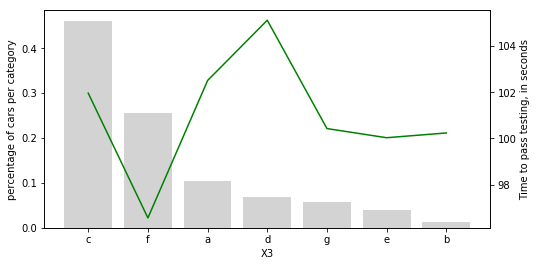

In [7]:
plot_categories(temp_df, 'X3')

Cars where X3 is f pass the test quicker, whereas cars with the category d take a longer time to pass the test.

Cars where X3 is b, take around 100 seconds to pass the test. However, b is present in less than 10% of the cars. Why is this important? Because if we do not have a lot of cars to learn from, we could be under or over-estimating the effect if b on the time to pass a test.

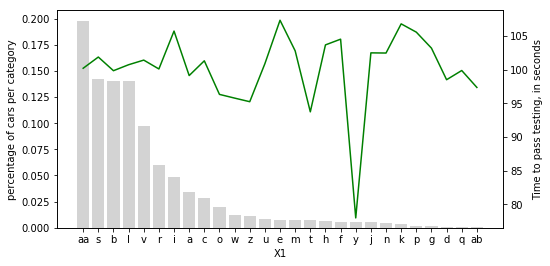

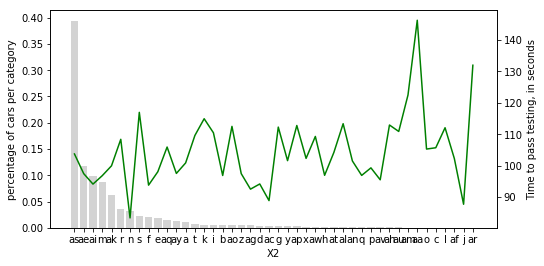

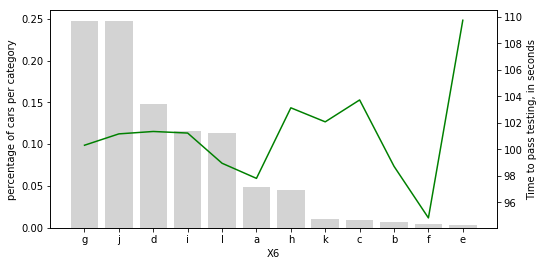

In [8]:
# let's plot the remaining categorical variables

for col in cols_to_use:
    
    if col !='X3':
        
        # re using the functions I created
        temp_df = calculate_perc_and_passtime(data, col)
        plot_categories(temp_df, col)

Let's look at variable X2: "y" varies a lot across the rare categories. The mean value of y goes up and down over the infrequent categories. In fact, it looks quite noisy. This rare labels could indeed be very predictive, or they could be introducing noise rather than information. And because the labels are under-represented, we can't be sure whether they have a true impact on the time to pass the test. We could be under or over-estimating their impact due to the fact that we have information for few cars.

This plot would bring more value, if we plotted the errors of the mean time to pass the test. it would give us an idea of how much the mean value of the target varies within each label. Why don't you go ahead and add the standard deviation to the plot?

### Rare labels: grouping under a new label

One common way of working with rare or infrequent values, is to group them under an umbrella category called 'Rare' or 'Other'.

In [9]:
# I will replace all the labels that appear in less than 10%
# of the cars by the label 'rare'

def group_rare_labels(df, var):
    
    total_cars = len(df)
    
    # first I calculate  the % of cars for each category 
    temp_df = pd.Series(df[var].value_counts() / total_cars)

    # now I create a dictionary to replace the rare labels with the
    # string 'rare'

    grouping_dict = {
        k: ('rare' if k not in temp_df[temp_df >= 0.1].index else k)
        for k in temp_df.index
    }

    # now I replace the rare categories
    tmp = df[var].map(grouping_dict)
    
    return tmp   

In [10]:
# group rare labels in X1

data['X1_grouped'] = group_rare_labels(data, 'X1')

data[['X1', 'X1_grouped']].head(10)

,X1,X1_grouped
0,v,rare
1,t,rare
2,w,rare
3,t,rare
4,v,rare
5,b,b
6,r,rare
7,l,l
8,s,s
9,b,b


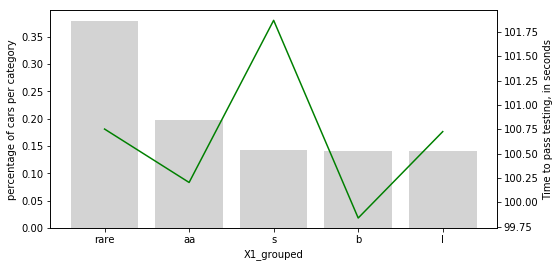

In [11]:
# let's plot X1 with the grouped categories
# re using the functions I created above

temp_df = calculate_perc_and_passtime(data, 'X1_grouped')
plot_categories(temp_df, 'X1_grouped')

Rare now contains the overall influence of all the infrequent categories on the time to pass the test.

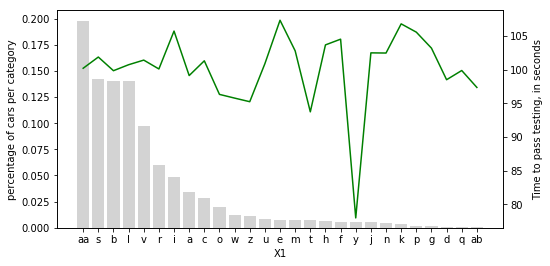

In [12]:
# let's plot the original X1 for comparison
temp_df = calculate_perc_and_passtime(data, 'X1')
plot_categories(temp_df, 'X1')

Only 4 categories of X1 are relatively common across the different cars. The remaining are now gouped into 'rare' which captures the average time to pass the test for all the infrequent labels.

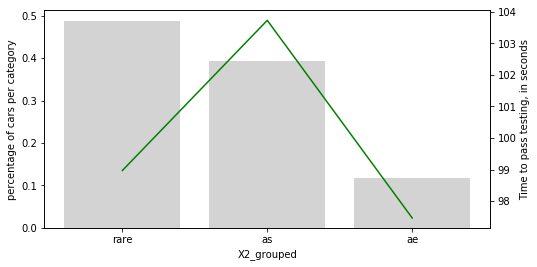

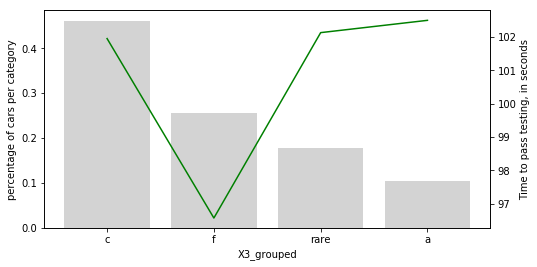

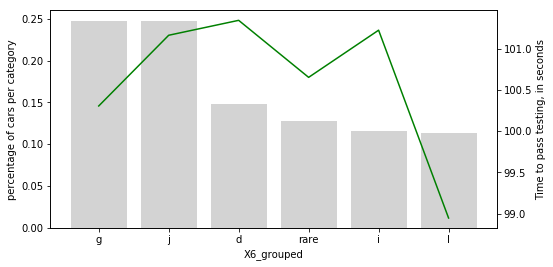

In [13]:
# let's group and plot the remaining categorical variables

for col in cols_to_use[1:]:
        
    # re using the functions I created
    data[col+'_grouped'] = group_rare_labels(data, col)
    temp_df = calculate_perc_and_passtime(data, col+'_grouped')
    plot_categories(temp_df, col+'_grouped')

Here we can see for example, that cars with the the label f for variable X3, tend to spend less time in testing, and all the infrequent labels together tend to behave overall like the features c and a, in terms of time to pass the test.

Note: Ideally, we would also like to have the standard deviation / interquantile range for the time to pass the test, to get an idea of how variable the time to pass is for each category.

### Rare labels lead to uneven distribution of categories in train and test sets

Similarly to highly cardinal variables, rare or infrequent labels often land only on the training set, or only on the testing set. If present only in the training set, they may lead to over-fitting. If present only on the testing set, the machine learning algorithm will not know how to handle them, as they have not seen the rare labels during training. Let's explore this further.

In [14]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data[cols_to_use], data.y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((2946, 4), (1263, 4))

In [15]:
# Let's find out labels present only in the training set
# I will use X2 as example

unique_to_train_set = [
    x for x in X_train['X2'].unique() if x not in X_test['X2'].unique()
]

print(unique_to_train_set)

['l', 'aa', 'au', 'o', 'af', 'c', 'am']


There are 7 categories present in the train set and are not present in the test set.

In [16]:
# Let's find out labels present only in the test set

unique_to_test_set = [
    x for x in X_test['X2'].unique() if x not in X_train['X2'].unique()
]

print(unique_to_test_set)

['ar', 'j']


In this case, there are 2 rare values present in the test set only.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**